In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from results.result_processing import get_trace_reduction
from results.utils import (
    make_precision_recall_at_k_df,
    get_precision_at_fpr,
    make_precision_recall_at_k_df_single_threshold,
    make_precision_recall_at_k_df_single_threshold_multi,
)
from results.final_model_metrics import get_final_model_metrics
from attacks import AttackConfig, LiRAAttack
from sklearn.metrics import roc_curve
import pandas as pd
import numpy as np
import pickle

from matplotlib import pyplot as plt
import os
from itertools import combinations

In [ ]:
attack = "LiRA"
augment = True
batchsize = 256
num_workers = 8
gpu = ":0"
dataset = "CIFAR10"
arch = "wrn28-2"
exp_id = f"{arch}_{dataset}"

all_dfs = {}

for shadow_seed in range(10):
    csv_path = f'data/trace_df_{arch}_{dataset}_seed{shadow_seed}.csv'
    if os.path.exists(csv_path):
        all_dfs[shadow_seed] = pd.read_csv(csv_path, index_col=0)
        continue

    config = AttackConfig(
        exp_id=exp_id,
        target_id="target",
        checkpoint=None,
        arch=arch,
        dataset=dataset,
        attack=attack,
        augment=augment,
        batchsize=batchsize,
        num_workers=num_workers,
        n_shadows=64,
        shadow_seed=shadow_seed,
        gpu=gpu,
    )
    attack = LiRAAttack(config)
    results = attack.run()

    df_final_model_metrics = get_final_model_metrics(
        model=attack.model, data_loader=attack.attack_loaders[0],
    )
    df_final_model_metrics = pd.merge(df_final_model_metrics, results, left_index=True, right_index=True)

    trace = get_trace_reduction(exp_id, reduction="iqr")
    trace_df = pd.DataFrame({'trace_value': trace})
    trace_df = pd.merge(trace_df, df_final_model_metrics, left_index=True, right_index=True)

    trace_df.to_csv(csv_path)
    all_dfs[shadow_seed] = trace_df

In [6]:
fpr_threshold = 0.001

all_positive_indices = []
for trace_df in all_dfs.values():
    y_true = trace_df["target_trained_on"].astype(int)
    y_score = trace_df["lira_score"]
    fpr, tpr, thresholds = roc_curve(y_true, y_score)

    # Find threshold corresponding to desired FPR
    idx = np.where(fpr > fpr_threshold)[0][0]
    threshold = thresholds[idx]

    # Get positive predictions at this threshold
    ground_truth_positives = trace_df[
        (trace_df["lira_score"] > threshold)
        & (trace_df["target_trained_on"] == True)
    ]
    positive_indices = set(ground_truth_positives.index)
    all_positive_indices.append(positive_indices)

In [8]:
def point_in_at_least_k_subsets(subsets, k):
    points = set() 
    for subset in combinations(subsets, k):
        points |= set.intersection(*subset)
    return points

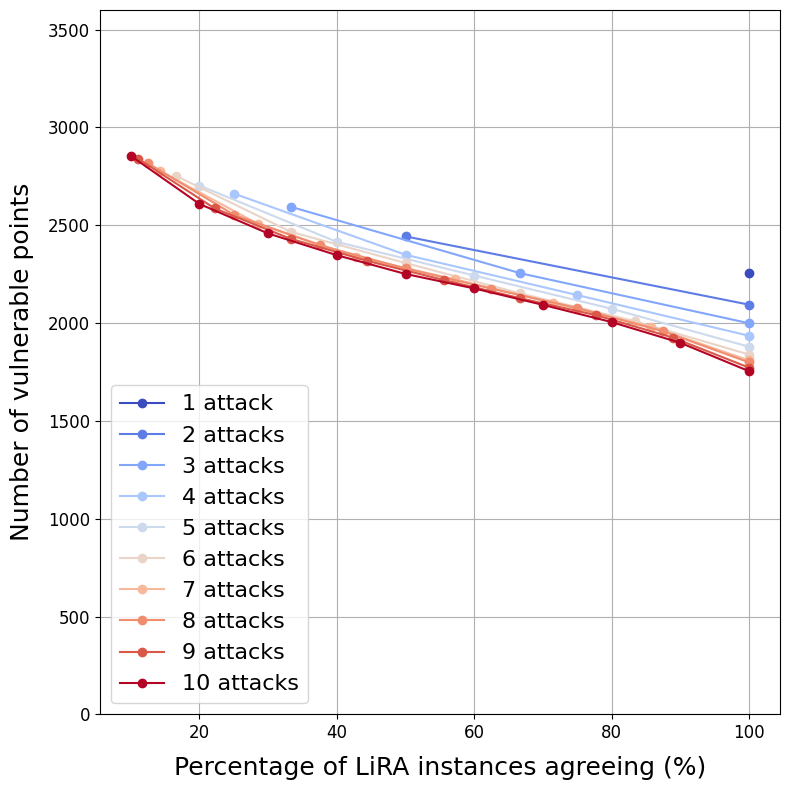

In [12]:
plt.figure(figsize=(8,8))

colors = plt.cm.coolwarm(np.linspace(0, 1, len(all_positive_indices)))   # Blue to red

# Create lines for each subset size from 2 to len(all_positive_indices)
for m_target_models in range(1, len(all_positive_indices) + 1):
    subsets = all_positive_indices[:m_target_models]
    
    at_least_k = []
    for k in range(1, len(subsets)+1):
        points = point_in_at_least_k_subsets(subsets, k=k) 
        at_least_k.append(len(points))
        
    # Convert x-axis to percentages
    x_vals = [k/len(subsets)*100 for k in range(1, len(at_least_k)+1)]
    plt.plot(x_vals, at_least_k, marker='o', color=colors[m_target_models-1],
             label=f'{len(subsets)} {"attack" if len(subsets)==1 else "attacks"}', alpha=1.0)

plt.xlabel('Percentage of LiRA instances agreeing (%)', fontsize=18, labelpad=10)
plt.ylabel('Number of vulnerable points', fontsize=18, labelpad=10)
plt.ylim(0,3600)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True)
plt.legend(loc='lower left', fontsize=16)
plt.tight_layout()
plt.savefig('figures/lira_agreement.pdf')


In [ ]:
df = pd.read_csv(f"data/trace_df_{arch}_{dataset}_seed0.csv", index_col=0)

df_res = pd.DataFrame()
for k in [5, 8, 10]:
    metrics = make_precision_recall_at_k_df_single_threshold_multi(
        scores_df=df,
        positive_indices=point_in_at_least_k_subsets(all_positive_indices, k=k),
        k_frac=0.01,
    )
    df_res[f'k={k}'] = metrics

df_res

,k=5,k=8,k=10
positives,2251.000000,2005.000000,1754.000000
precision_random_guess,0.090040,0.080200,0.070160
recall_random_guess,0.010000,0.010000,0.010000
overlap_loss_desc,49.000000,41.000000,39.000000
precision_loss_desc,0.196000,0.164000,0.156000
recall_loss_desc,0.021768,0.020449,0.022235
overlap_loss_asc,4.000000,4.000000,3.000000
precision_loss_asc,0.016000,0.016000,0.012000
recall_loss_asc,0.001777,0.001995,0.001710
overlap_confidence_desc,4.000000,4.000000,3.000000
